In [175]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster import DBSCAN, MeanShift, KMeans, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score

# for the dendogram
import scipy.cluster.hierarchy as sch

# 1.About the Data
<div style="text-align: justify">
The data used in the current report is called 'Customer Personality Analysis' from Kaggle. The dataset has data about the customer itself like year of birth and education, also how much the amount spent on certain type of product, how the customer respond to the promotion, and where the customer buy the company product. The data  has 2240 rows and 29 variables that also included Customer ID. Here is the description of almost all variables in the dataset:  </div>

### People

* ID: Customer's unique identifier
* Year_Birth: Customer's birth year
* Education: Customer's education level
* Marital_Status: Customer's marital status
* Income: Customer's yearly household income
* Kidhome: Number of children in customer's household
* Teenhome: Number of teenagers in customer's household
* Dt_Customer: Date of customer's enrollment with the company
* Recency: Number of days since customer's last purchase
* Complain: 1 if the customer complained in the last 2 years, 0 otherwise

### Products

* MntWines: Amount spent on wine in last 2 years
* MntFruits: Amount spent on fruits in last 2 years
* MntMeatProducts: Amount spent on meat in last 2 years
* MntFishProducts: Amount spent on fish in last 2 years
* MntSweetProducts: Amount spent on sweets in last 2 years
* MntGoldProds: Amount spent on gold in last 2 years

### Promotion

* NumDealsPurchases: Number of purchases made with a discount
* AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
* AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
* AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
* AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
* AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
* Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

### Place

* NumWebPurchases: Number of purchases made through the company’s website
* NumCatalogPurchases: Number of purchases made using a catalogue
* NumStorePurchases: Number of purchases made directly in stores
* NumWebVisitsMonth: Number of visits to company’s website in the last month

Here is the links to the dataset https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis.

In [2]:
# calling the data
data=pd.read_csv('D:/Dataset ML/Customer Personality/marketing_campaign.csv', sep='\t')
#check the overview of the data
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
# see the data type and the missing value
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

From the data i could see the fact that most of the data are interger but this doesn't mean that most of them are numeric variables. Based on the data description, it could be said that there is quite large variables that is categorical albeit being binary variabes. Here is the summary for the variable type (i will not disscuss Z_CostContact,Z_Revenue, and ID as they are non needed in the clustering steps) for mean time before assesing them later on:
- **Numerical Interger**: Year_Birth, Kidhome, Teenhome, Recency, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth
- **Numerical Continuous**: Income
- **Date time**: Dt_Customer
- **Binary categorical**: AcceptedCmp1, AcceptedCmp2, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, Complain
- **Nominal**: Education, Marital_Status
Aside from all of those, there is missing value only in one variables that is income which only 24 Missing value that will be dropped.

In [4]:
#duplicating the dataset
data_orig=data.copy()

In [5]:
# getting the index of row for the missing value
ind=np.where(data.isna().any(axis=1))[0]
ind=ind.tolist()

# rows with missing value
Nan=data.iloc[ind,:]

# dropping the rows
data=data.drop(labels=ind,axis=0)

# 2.The Plan and Objective

My analysis here will be focused on the clustering algorithm itself. I plan to get customer segmentation especially on the spend ammount by the customer in fish, meat, and fruits or daily necessities as far as i concern. The benefit of this analysis is that i able to get different customer characteristics that perhaps has different behviour on buying daily necessities which allows for targeting of promotion or marketing for new daily necessities or even keeping customer engaged. As perhaps i do not have deep knowledge about marketing or customer behaviour, perhaps i will not have 'sophisticated' analysis in this report.

As this is unsupervised learning in which target variables is not present, i will instead compare the result of different clustering method using data analysis of the feature that prevalent on those cluster. I shall compare spending amount, number of cluster (because if there is too many cluster it can become unreasonable), demographics, place of buying, and respond to promotion. The data analysis is such to see which algorithm produces 'distict' result in logical real life situation. As such the algorithm i shall use is K-Means, Hierarchical Clustering, DBSCAN, and MeanShift (which the epsilon shall be tuned later). Additionally perhaps since there binary variables, i think scaling is necessary to ensure each variables has equal influence to the result of clustering. There is some variables that can be combined to reduced dimensionality and simplify analysis which also will be done later on.

**Disclaimer**: I admit that few of the idea in this analysis is coming from many sources including those from Kaggle. Therefore i am very grateful for their sharing of their result.

# 3.Data Preprocessing
Will be divided in three steps:
1. Viewing category in multiclass nominal variable
2. Handle datetime data -> convert and perhaps change it into categorical if necessary
3. Reduce dimensionality by combining few variables into one
4. Doing scaling for the numerical/interger data

Output: Dataframe that already ready for clustering which already has dimensionality reduction and valuable information (through features)

## 3.a.Handle Category in Nominal Variables

In [6]:
# getting the nominal variables first
cat=['Marital_Status','Education']
categog=data[cat]
#see the unique value in the nominal variables
ms=categog[cat[0]].value_counts()
print(ms)
edu=categog[cat[1]].value_counts()
print(edu)

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


From the Marital_Status, i think there is quite overlap between categories. The category alone can be merged to single. Additionally since i am not familiar with the difference in spending habits for person thai is Together (i assumed that it mean that the customer is cohabiting) and Married, i will merge the two. Category of absurd and YOLO under my discretion will be placed on the single instead. In the end there will be only Relationship, Single, Divorced, and Widow. 

For the Education, i think that Master, Graduation, and 2n Cycle can constitute a single category that is Graduate because there is overlapp between their level anyway. Mean while PhD and Basic remain different category because they represented different level of education completely.

In [7]:
# replace for the marital status
data[cat[0]]=data[cat[0]].replace(['Alone','Absurd','YOLO'],'Single')
data[cat[0]]=data[cat[0]].replace(['Together','Married'],'Relationship')
data[cat[0]].value_counts()

Relationship    1430
Single           478
Divorced         232
Widow             76
Name: Marital_Status, dtype: int64

In [8]:
# replace for the education
data[cat[1]]=data[cat[1]].replace(['Graduation','Master','2n Cycle'],'Graduate')
data[cat[1]].value_counts()

Graduate    1681
PhD          481
Basic         54
Name: Education, dtype: int64

## 3.b.Handle Datetime Variable
The goal here is to see how many years the customer is engaging with the company. As such although this is already 2023, the data come from as far as i know come from 2021. Therefore there is the need to determined the last date. Since the last customer enroll to the company in 2014, to ensure fairness and reduce the inaccuracy, i will use the end of 2016 as the last day because the description in the data show that at least there is the need for 2 years of transaction. I will also convert the Year_Birth to become Age with limitation in which the 2017 is considered as the last year and i assumed that the people is still alive in that year.

In [9]:
# convert the object type to datetime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')

In [10]:
data['Dt_Customer'].min()

Timestamp('2012-07-30 00:00:00')

In [11]:
# the last day of the data measurement
data['last_day'] = pd.to_datetime('31-12-2016', format='%d-%m-%Y')
# search for the days in which they were engaged on
data['day_engaged'] = (data['last_day']-data['Dt_Customer']).dt.days

In [12]:
data['day_engaged'].describe()

count    2216.000000
mean     1269.521209
std       202.434667
min       916.000000
25%      1096.000000
50%      1271.500000
75%      1445.000000
max      1615.000000
Name: day_engaged, dtype: float64

In [13]:
# search for the months in which they were engaged on -> to simplify interpretation later on
data['month_engaged'] = (data['day_engaged'])//30

In [14]:
data['month_engaged'].describe()

count    2216.000000
mean       41.831227
std         6.765030
min        30.000000
25%        36.000000
50%        42.000000
75%        48.000000
max        53.000000
Name: month_engaged, dtype: float64

In [15]:
data['age']=2017-data['Year_Birth']

In [16]:
data['age'].max()

124

In [17]:
data[data['age']>80]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,last_day,day_engaged,month_engaged,age
192,7829,1900,Graduate,Divorced,36640.0,1,0,2013-09-26,99,15,...,0,0,1,3,11,0,2016-12-31,1192,39,117
239,11004,1893,Graduate,Single,60182.0,0,1,2014-05-17,23,8,...,0,0,0,3,11,0,2016-12-31,959,31,124
339,1150,1899,PhD,Relationship,83532.0,0,0,2013-09-26,36,755,...,0,0,0,3,11,0,2016-12-31,1192,39,118


Seeing the fact that all almost cetenarians in the group is only around 1 month from shopping, it safe to assumed that they still alive although their future value (i'm sorry if sound bad but i seeing it from the perspective of business) is quite unknown and perhaps very limited.

## 3.c.Merge Some Variable
Since i want to see segmenting when buying the daily necessities anyway, the 3 variables included that is for buying fish, meat, and fruit become redundant as such just combine them. I admit this will 'decrease' the insight into the detailed behaviour but the goal here is to see the clustering in the buying of daily necesitites and i saw that seperating them is not good option.

Additionally i assumed that there is 6 promotion in which the customer has variety of response. To simplify the situation i assume that there is no targeted advertisement yet and all the offer is related to the grocery and the AcceptedCmp1 is the earliest promotion while response the the recent promotion. As such while number of accepting offer is good, it does not show the recent condition which could be seen in the few promotion (because people changed). Therefore split the 6 promotion indicator into 2 could be bridge between number and order in the promotion in my opinion

In [18]:
data['grocery']=data['MntMeatProducts']+data['MntFishProducts']+data['MntFruits']
data['grocery'].describe()

count    2216.000000
mean      230.989621
std       285.194608
min         1.000000
25%        25.000000
50%        90.000000
75%       360.250000
max      1727.000000
Name: grocery, dtype: float64

In [19]:
data['early_offer']=data['AcceptedCmp1']+data['AcceptedCmp2']+data['AcceptedCmp3']
data['recent_offer']=data['AcceptedCmp4']+data['AcceptedCmp5']+data['Response']
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Z_CostContact,Z_Revenue,Response,last_day,day_engaged,month_engaged,age,grocery,early_offer,recent_offer
0,5524,1957,Graduate,Single,58138.0,0,0,2012-09-04,58,635,...,3,11,1,2016-12-31,1579,52,60,806,0,1
1,2174,1954,Graduate,Single,46344.0,1,1,2014-03-08,38,11,...,3,11,0,2016-12-31,1029,34,63,9,0,0
2,4141,1965,Graduate,Relationship,71613.0,0,0,2013-08-21,26,426,...,3,11,0,2016-12-31,1228,40,52,287,0,0
3,6182,1984,Graduate,Relationship,26646.0,1,0,2014-02-10,26,11,...,3,11,0,2016-12-31,1055,35,33,34,0,0
4,5324,1981,PhD,Relationship,58293.0,1,0,2014-01-19,94,173,...,3,11,0,2016-12-31,1077,35,36,207,0,0


## 3.d.Convert the Categorical into Numerical

In [20]:
# Perform one-hot encoding on the isolated column
encoded = pd.get_dummies(data[['Education','Marital_Status']], prefix=['Education','Marital_Status'])

# Combine the original DataFrame with the encoded column
data_encoded = pd.concat([data, encoded], axis=1)

# Drop the original "Color" column if needed
data_encoded.drop(columns=['Education','Marital_Status'], inplace=True)

## 3.e.Scaling The Numerical Variable
I will use standard scaler

In [21]:
da=data_encoded.copy()
da.head()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,grocery,early_offer,recent_offer,Education_Basic,Education_Graduate,Education_PhD,Marital_Status_Divorced,Marital_Status_Relationship,Marital_Status_Single,Marital_Status_Widow
0,5524,1957,58138.0,0,0,2012-09-04,58,635,88,546,...,806,0,1,0,1,0,0,0,1,0
1,2174,1954,46344.0,1,1,2014-03-08,38,11,1,6,...,9,0,0,0,1,0,0,0,1,0
2,4141,1965,71613.0,0,0,2013-08-21,26,426,49,127,...,287,0,0,0,1,0,0,1,0,0
3,6182,1984,26646.0,1,0,2014-02-10,26,11,4,20,...,34,0,0,0,1,0,0,1,0,0
4,5324,1981,58293.0,1,0,2014-01-19,94,173,43,118,...,207,0,0,0,0,1,0,1,0,0


In [22]:
scaler=StandardScaler()

In [23]:
# decided which variables going to be scaled
numeric=['age','Income','Kidhome','Teenhome','Recency','grocery','NumDealsPurchases','NumWebPurchases',
         'NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth','month_engaged','early_offer','recent_offer']

In [24]:
da[numeric]=scaler.fit_transform(da[numeric])

In [25]:
da[numeric].describe()

,age,Income,Kidhome,Teenhome,Recency,grocery,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,month_engaged,early_offer,recent_offer
count,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03
mean,9.108238e-17,5.859858e-17,-2.310627e-16,1.619242e-16,-1.175353e-16,3.612233e-17,1.223700e-16,-1.499252e-16,-1.462428e-16,4.478968e-17,6.773563e-17,-1.764533e-16,1.921848e-16,3.617243e-17
std,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00
min,-2.268209e+00,-2.007250e+00,-8.230393e-01,-9.289722e-01,-1.693488e+00,-8.066125e-01,-1.208121e+00,-1.490800e+00,-9.128373e-01,-1.784893e+00,-2.193591e+00,-1.749275e+00,-3.687909e-01,-4.700377e-01
25%,-6.826092e-01,-6.732620e-01,-8.230393e-01,-9.289722e-01,-8.642385e-01,-7.224404e-01,-6.881759e-01,-7.609619e-01,-9.128373e-01,-8.618303e-01,-9.563810e-01,-8.621608e-01,-3.687909e-01,-4.700377e-01
50%,-9.844093e-02,-3.439972e-02,-8.230393e-01,-9.289722e-01,-4.365786e-04,-4.944744e-01,-1.682312e-01,-3.112352e-02,-2.293274e-01,-2.464554e-01,2.808287e-01,2.495342e-02,-3.687909e-01,-4.700377e-01
75%,8.195377e-01,6.466600e-01,1.039938e+00,9.090657e-01,8.633654e-01,4.533380e-01,3.517135e-01,6.987149e-01,4.541825e-01,6.766069e-01,6.932320e-01,9.120676e-01,-3.687909e-01,-4.700377e-01
max,6.327410e+00,2.441328e+01,2.902916e+00,2.747104e+00,1.727167e+00,5.246761e+00,6.591050e+00,8.362018e+00,8.656301e+00,2.215044e+00,6.054474e+00,1.651329e+00,6.949782e+00,4.271708e+00


# 4.Do Clustering
In this section i will tune the hyperparameter for the clustering and do the clustering

In [26]:
# the final df
exclude=['ID','Year_Birth','Dt_Customer','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntGoldProds', 
         'MntSweetProducts','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response',
         'Z_CostContact','Z_Revenue','last_day','day_engaged']
df=da.drop(columns=exclude)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Income                       2216 non-null   float64
 1   Kidhome                      2216 non-null   float64
 2   Teenhome                     2216 non-null   float64
 3   Recency                      2216 non-null   float64
 4   NumDealsPurchases            2216 non-null   float64
 5   NumWebPurchases              2216 non-null   float64
 6   NumCatalogPurchases          2216 non-null   float64
 7   NumStorePurchases            2216 non-null   float64
 8   NumWebVisitsMonth            2216 non-null   float64
 9   Complain                     2216 non-null   int64  
 10  month_engaged                2216 non-null   float64
 11  age                          2216 non-null   float64
 12  grocery                      2216 non-null   float64
 13  early_offer       

## 4.a.Tune Hyperparameter

### K-Means and Hierachical Clustering 

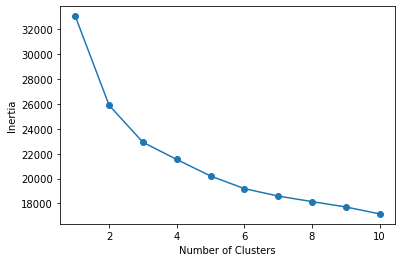

In [28]:
# for k-Means
inertia = []
list_num_clusters = list(range(1,11))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(df)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

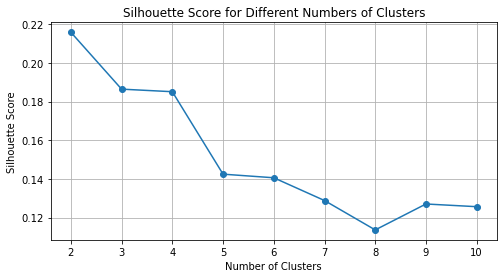

In [29]:
#for k means
silhouette_scores = []
range_n_clusters = list(range(2,11))

# run through the cluster number for the silhoutte score
for n_clusters in range_n_clusters:
    model = KMeans(n_clusters=n_clusters)
    cluster_labels = model.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Create a plot to visualize the Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)
plt.show()

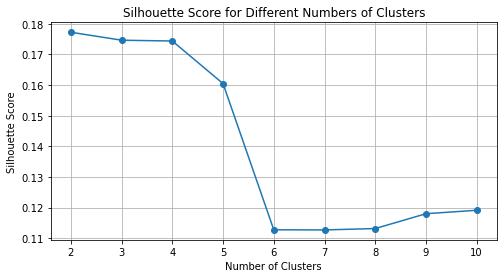

In [30]:
# for hierarchical one
silhouette_scores = []
range_n_clusters = list(range(2,11))

# run through the cluster number for the silhoutte score
for n_clusters in range_n_clusters:
    model = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = model.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Create a plot to visualize the Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)
plt.show()

### DBSCAN 

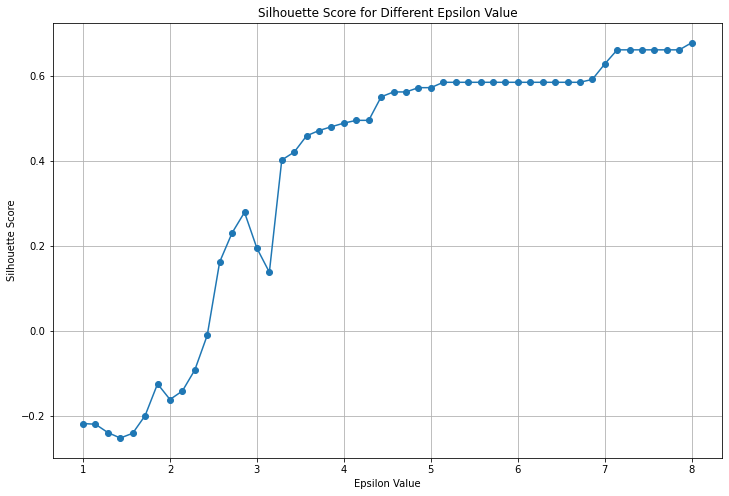

In [91]:
# for DBSCAN one
silhouette_scores = []
range_eps = np.linspace(1,8,50)

# run through the cluster number for the silhoutte score
for eps in range_eps:
    model = DBSCAN(eps=eps)
    cluster_labels = model.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    #print(eps)

# Create a plot to visualize the Silhouette Scores
plt.figure(figsize=(12, 8))
plt.plot(range_eps, silhouette_scores, marker='o')
plt.xlabel('Epsilon Value')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Epsilon Value')
plt.grid(True)
plt.show()

### Mean Shift

In [119]:
# for Mean Shift one
silhouette_scores = []
range_bandwidth = np.linspace(4,15,50)

# run through the cluster number for the silhoutte score
for ban in range_bandwidth:
    model = MeanShift(bandwidth=ban)
    cluster_labels = model.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    #print(eps)

# Create a plot to visualize the Silhouette Scores
plt.figure(figsize=(12, 8))
plt.plot(range_eps, silhouette_scores, marker='o')
plt.xlabel('Epsilon Value')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Bandwidth Value')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

## 4.b. Clustering
In this section i will use the resulting parameter in the above plot to the clustering it self

### K-Means
From the elbow method it could be said that 2 cluster is the point in which the error decrease will stagnated. However the sihoutte score suggest that i should choose 3 because the cluster 3 will stagnate the score in silhoutte score before taking a dive after 4 cluster.

In [120]:
km=KMeans(n_clusters=3)

km=km.fit(df)
data_encoded['Kmeans']=km.predict(df)

### Hierarchical Clustering
From the plot it silhoutte score, it could be said that the 3 cluster is also the value in which the optimal sihoutte score can get because after the 4 is also going to plunge in value

In [121]:
agg=AgglomerativeClustering(n_clusters=3)

agg=agg.fit(df)
data_encoded['Hierarchical']=agg.fit_predict(df)

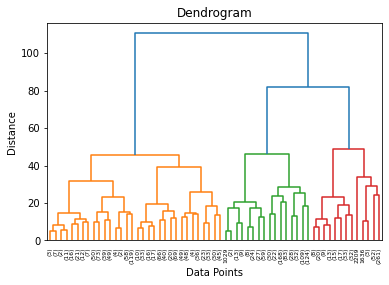

In [122]:
Z = sch.linkage(df, method='ward')

dendrogram = sch.dendrogram(Z, truncate_mode='level', p=5)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.show()

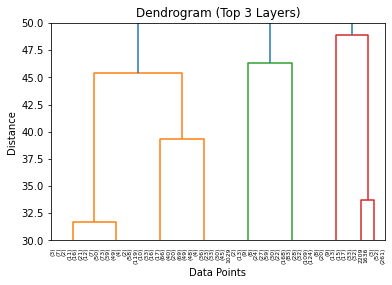

In [123]:
# zoom up the subcluster
dendrogram = sch.dendrogram(Z, truncate_mode='level', p=5)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.ylim(30,50)
plt.title('Dendrogram (Top 3 Layers)')
plt.show()

In [124]:
cutting_threshold = 30  # Adjust this value based on your visual inspection

# Cut the dendrogram and get cluster assignments at that level
subcluster_assignments = sch.fcluster(Z, t=cutting_threshold, criterion='distance')

# Now, subcluster_assignments contains the subcluster assignments
unique_subclusters = np.unique(subcluster_assignments)
num_subclusters = len(unique_subclusters)

print(f"Number of subclusters: {num_subclusters}")
data_encoded['Hierarchical_subcluster']=subcluster_assignments

Number of subclusters: 9


### DBSCAN
From the plot in sihoutte score, i see that the score will be stagnated after epilon value of 5 therefore i will use that number

In [125]:
db=DBSCAN(eps=5)

#fir and predict
db=db.fit(df)
# krn algoritma hanya buat cluster bukan lgsg mengklasifikasikan maka
data_encoded['DBSCAN']=db.labels_

In [126]:
# see how many cluster it 
print(f'DBSCAN found {len(set(db.labels_) - set([-1]))} clusters and {(db.labels_ == -1).sum()} points of noise.')

DBSCAN found 1 clusters and 12 points of noise.


### Mean Shift
I will use bandwidth value of 6 because afterthat the sihoutte score is stagnating.

In [127]:
ms=MeanShift(bandwidth=6)

ms=ms.fit(df)
data_encoded['MeanShift']=ms.predict(df)

In [128]:
data_encoded['MeanShift'].value_counts()

0    2205
1       3
2       3
3       2
5       1
6       1
4       1
Name: MeanShift, dtype: int64

## 4.c.Conclusion
From the above result, the DBSCAN and MeanShift algorithm could not be discussed later on because they only produced 1 effective cluster anyway. This suggest that my data is perhaps not dense enough or the hyperparameter is too large. In the next section, i shall discussed the comparative result of K-Means and Hierarchical Clustering. 

# 5.Result Analysis
In this section, i will do data analysis with the help of visualisation to get understanding about the characteristics created by each cluster's algorithm. The output of this analysis will be a conclusion of the characteristics in each cluster. The data used for the analysis will be the data before the scaling so that i know the exact number for the numerical variable. I hope to see quite distinct characteristics between cluster

In [129]:
# the data should use the already preprocessed without scaling
exclude=['ID','Year_Birth','Dt_Customer','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntGoldProds',
         'MntSweetProducts','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response',
         'Z_CostContact','Z_Revenue','last_day','day_engaged']
DATA=data_encoded.drop(columns=exclude)

In [130]:
# reverting the one hot encoding for education and marital status
# for education
enco=['Education_Basic','Education_Graduate', 'Education_PhD']
DATA['Education']=DATA[enco].idxmax(axis=1)
DATA['Education'] = DATA['Education'].str.replace('Education_', '')

# Drop the original one-hot encoded columns
DATA.drop(columns=enco, inplace=True)

In [131]:
# for marital status
enco1=['Marital_Status_Divorced','Marital_Status_Relationship', 'Marital_Status_Single','Marital_Status_Widow']
DATA['Marital_Status']=DATA[enco1].idxmax(axis=1)
DATA['Marital_Status'] = DATA['Marital_Status'].str.replace('Marital_Status_', '')

# Drop the original one-hot encoded columns
DATA.drop(columns=enco1, inplace=True)

In [132]:
DATA.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Complain', 'month_engaged', 'age', 'grocery',
       'early_offer', 'recent_offer', 'Kmeans', 'Hierarchical',
       'Hierarchical_subcluster', 'DBSCAN', 'MeanShift', 'Education',
       'Marital_Status'],
      dtype='object')

In [133]:
# dividing characteristics like the data description
people=['Income','age','Education', 'Marital_Status', 'Kidhome', 'Teenhome', 'Recency','month_engaged',
        'Kmeans','Hierarchical', 'Hierarchical_subcluster']
product=['grocery','Kmeans','Hierarchical', 'Hierarchical_subcluster']
promo=['early_offer', 'recent_offer','NumDealsPurchases','Kmeans','Hierarchical', 'Hierarchical_subcluster']
place=['NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth','Kmeans','Hierarchical', 
       'Hierarchical_subcluster']

In [134]:
rem=['Education', 'Marital_Status', 'Kidhome', 'Teenhome']
num_people=[x for x in people if x not in rem]

## 5.a.People

### KMeans

In [150]:
num_person=['Income','age','Recency','month_engaged']
for col in num_person:
    summary_stats = DATA.groupby('Kmeans')[col].describe()
    print(f'Summary for:',col)
    print(summary_stats)
    print('---------------------------------------------------------')

Summary for: Income
        count          mean           std     min       25%      50%      75%  \
Kmeans                                                                          
0       520.0  78329.765385  28855.969713  2447.0  70512.00  77362.5  82631.5   
1       990.0  34005.625253  13101.581311  1730.0  25371.00  34011.0  41628.0   
2       706.0  58615.951841  11290.646361  4428.0  51208.75  58984.5  65838.0   

             max  
Kmeans            
0       666666.0  
1       162397.0  
2       113734.0  
---------------------------------------------------------
Summary for: age
        count       mean        std   min   25%   50%   75%    max
Kmeans                                                            
0       520.0  48.203846  14.002091  22.0  37.0  47.0  60.0  118.0
1       990.0  44.784848  10.977833  21.0  37.0  44.0  51.0  117.0
2       706.0  52.922096   9.961822  25.0  45.0  52.0  61.0  124.0
---------------------------------------------------------
Summary for

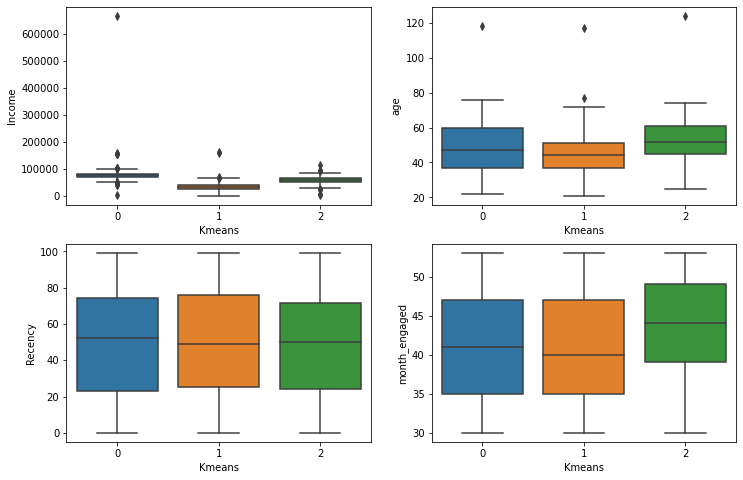

In [146]:
row=2
col=2
fig, axes = plt.subplots(row, col,figsize=(12,8))
plt.subplots_adjust(hspace=0.2) 
#plt.figure(figsize=(4,3))
for i in range(row):
    for j in range(col):
        plt.sca(axes[i][j])
        sns.boxplot(data=DATA, y=num_people[i*col+j],x='Kmeans')
plt.show()

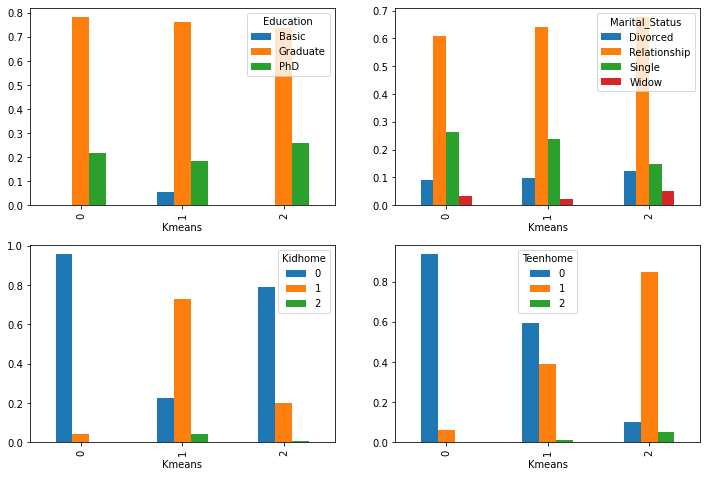

In [185]:
row=2
col=2
fig, axes = plt.subplots(row, col,figsize=(12,8))
plt.subplots_adjust(hspace=0.2) 
#plt.figure(figsize=(4,3))
for i in range(row):
    for j in range(col):
        pivot=DATA.groupby(['Kmeans',rem[i*col+j]]).size().unstack().fillna(0)
        pivot_percent=pivot.divide(pivot.sum(axis=1),axis=0)

        pivot_percent.plot(kind='bar',stacked=False,ax=axes[i,j])
plt.show()

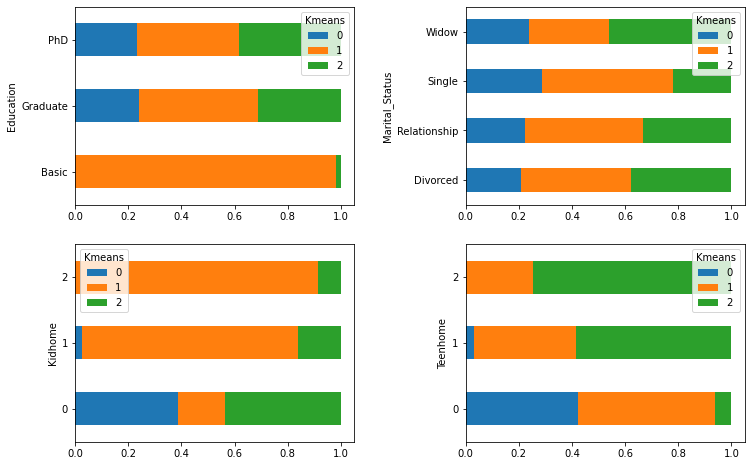

In [192]:
row=2
col=2
fig, axes = plt.subplots(row, col,figsize=(12,8))
plt.subplots_adjust(wspace=0.4) 
#plt.figure(figsize=(4,3))
for i in range(row):
    for j in range(col):
        pivot=DATA.groupby([rem[i*col+j],'Kmeans']).size().unstack().fillna(0)
        pivot_percent=pivot.divide(pivot.sum(axis=1),axis=0)

        pivot_percent.plot(kind='barh',stacked=True,ax=axes[i,j])
plt.show()

From the result of visualisation above, here is the characteristics of each cluster (with the exception of rencency):
- **Cluster 0**: This cluster composed of the second oldest adult (but also has the most spread age) with the highest income of any cluster. It also has the highest level of graduate and second most of PhD while also is the cluster with the highest level of single. It does dominated by people who has or in the past has couple (relationship, widow, and divorced) but it also the cluster with childless adult or person (because both person who has or were having couple and single didn't have any kid or teen). In a conclusion, this cluster is mostly high income, has sufficient education (Master level), and childless with quite diverse age. This high income is perhaps due to the less burden of not having a child but can also suggest that the people here are relatively wealthy with their money belonging truly to themself.

- **Cluster 1**: This cluster is the largest by count. This cluster composed of the youngest adult (with most concentrated age) with the lowest income of any cluster. It is also cluster with the most people that has people with basic education, the second highest in terms of PhD and Master level education (so in average has the lowest educational level of any cluster). It has the second most in terms of level relationship and single status with also the highest level of divorced and the lowest widow. It has the most kids and the second highest teen but in total the highest ammount of children from any group. In conclusion, the people in this group is the youngest, the lowest income and educational level, has the highest burden for children since they has the most kids (the teen in the near future could be independent) but present the most potential to grow as perhaps their children could also become customer and also their young age mean that they still can develop better. 

- **Cluster 2**: This cluster is the oldest, has the second highest income, and also has the most teen which suggest that this cluster will has less burden in near future. It has the highest ammoung of PhD and in average the highest educational level which is logical since they also is the oldest group. It is the group with the most trouble in marriage both divorced and widowed but also the lowest that has single status (once again because old). In conclusion, this cluster is old, matured, has children but in the near future could be adult, and also the earliest in touch with the company.

### Hierarchical Agglomerative Clustering

In [193]:
num_person=['Income','age','Recency','month_engaged']
for col in num_person:
    summary_stats = DATA.groupby('Hierarchical')[col].describe()
    print(f'Summary for:',col)
    print(summary_stats)
    print('---------------------------------------------------------')

Summary for: Income
               count          mean           std     min      25%      50%  \
Hierarchical                                                                 
0              465.0  78766.713978  29888.942534  2447.0  70666.0  78128.0   
1             1012.0  35280.549407  14874.469292  3502.0  25814.5  34499.0   
2              739.0  58794.953992  12503.654085  1730.0  51231.0  59354.0   

                  75%       max  
Hierarchical                     
0             83145.0  666666.0  
1             42665.5  162397.0  
2             66966.0  113734.0  
---------------------------------------------------------
Summary for: age
               count       mean        std   min   25%   50%    75%    max
Hierarchical                                                              
0              465.0  49.490323  14.963476  22.0  37.0  48.0  61.00  124.0
1             1012.0  45.762846  11.198023  21.0  38.0  44.5  53.25   77.0
2              739.0  50.664411  10.164819  

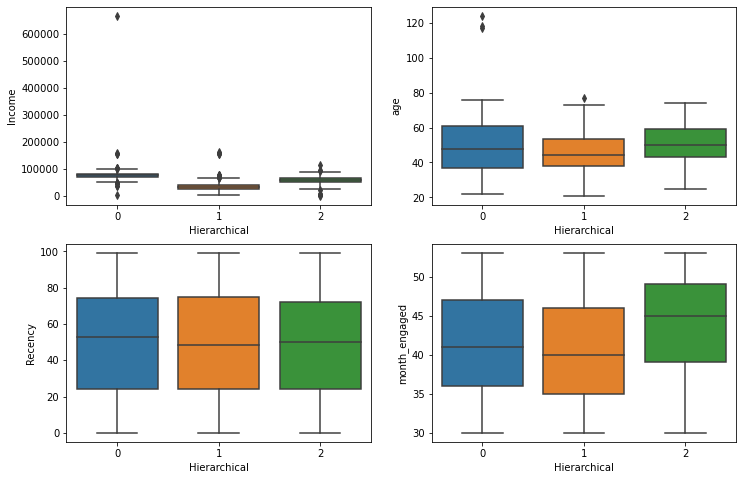

In [194]:
row=2
col=2
fig, axes = plt.subplots(row, col,figsize=(12,8))
plt.subplots_adjust(hspace=0.2) 
#plt.figure(figsize=(4,3))
for i in range(row):
    for j in range(col):
        plt.sca(axes[i][j])
        sns.boxplot(data=DATA, y=num_people[i*col+j],x='Hierarchical')
plt.show()

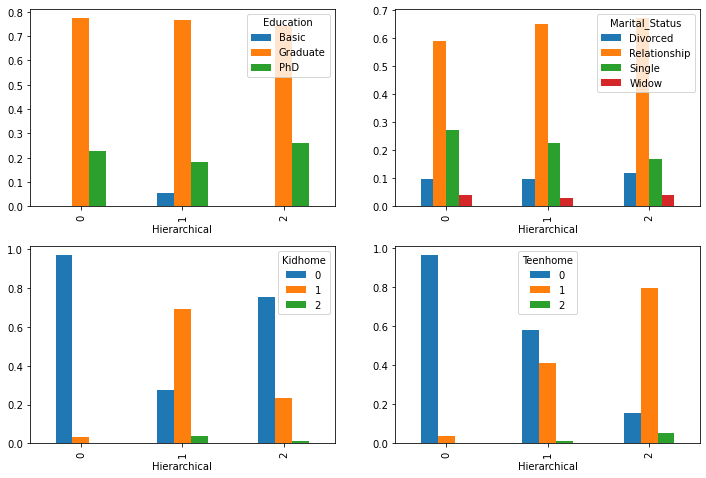

In [195]:
# make plot to see composition of each cluster 
row=2
col=2
fig, axes = plt.subplots(row, col,figsize=(12,8))
plt.subplots_adjust(hspace=0.2) 
#plt.figure(figsize=(4,3))
for i in range(row):
    for j in range(col):
        pivot=DATA.groupby(['Hierarchical',rem[i*col+j]]).size().unstack().fillna(0)
        pivot_percent=pivot.divide(pivot.sum(axis=1),axis=0)

        pivot_percent.plot(kind='bar',stacked=False,ax=axes[i,j])
plt.show()

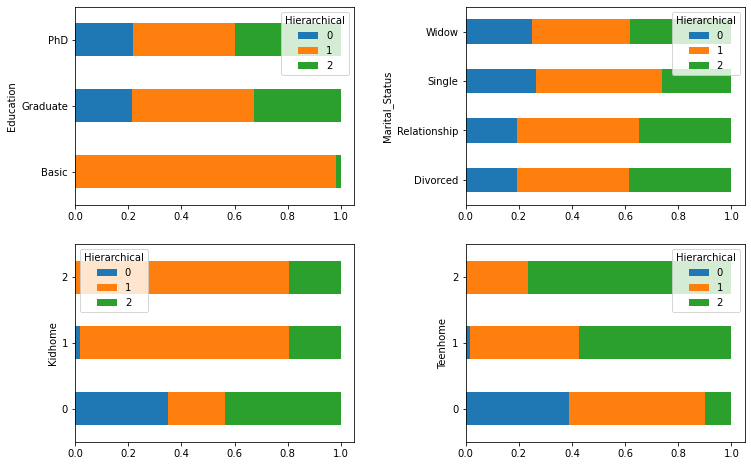

In [196]:
# make plot to see distribution of each category in the variable to each cluster
row=2
col=2
fig, axes = plt.subplots(row, col,figsize=(12,8))
plt.subplots_adjust(wspace=0.4) 
#plt.figure(figsize=(4,3))
for i in range(row):
    for j in range(col):
        pivot=DATA.groupby([rem[i*col+j],'Hierarchical']).size().unstack().fillna(0)
        pivot_percent=pivot.divide(pivot.sum(axis=1),axis=0)

        pivot_percent.plot(kind='barh',stacked=True,ax=axes[i,j])
plt.show()

The result of hierarchical clustering are almost identical to the K-means with the exception of month engaged and age
- **Cluster 0**: It become the oldest (perhaps? the plot is to closely tied) cluster and with the second earliest touch with the company
- **Cluster 1**: It is the most recent to be in touvh with the company and still the youngest
- **Cluster 2**: It is still the earliest to be in touvh with the company and also still the oldest (depend on your sight)

## 5.b.Products

### K-Means

<AxesSubplot:xlabel='Kmeans', ylabel='grocery'>

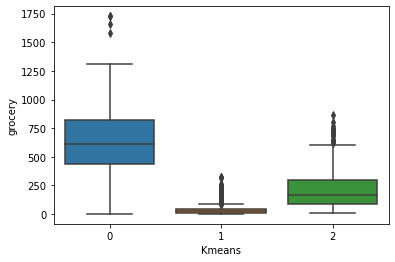

In [198]:
sns.boxplot(data=DATA, y=product[0],x='Kmeans')

Here is the characteristics (i will try to link it with the previous analysis):
- **Cluster 0**: It has the highest ammount spend on grocery (mean, fish, and fruits) probably because they has the highest income and has no burden both financially and children which perhaps indicate they has the time or lifestyle that support their shopping
- **Cluster 1**: It has the lowest spent on grocery and perhaps because they still struggle financially and has children which also indicate that perhaps they has the lowest time and resources to do shopping
- **Cluster 2**: It has the second highest spent on grocery but they perhaps not quite has the time to do the lifestyle for cook or consumption. And since it also has the highest PhD then perhaps they are busy and did not has any time to cook.

### Hierarchical Agglomerative Clustering

<AxesSubplot:xlabel='Hierarchical', ylabel='grocery'>

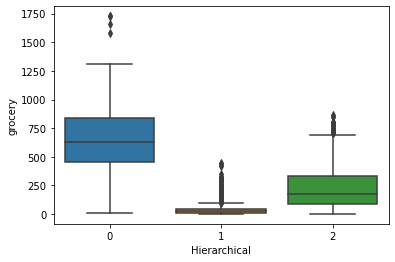

In [199]:
sns.boxplot(data=DATA, y=product[0],x='Hierarchical')

It literally is identical to the K-Means

## 5.c.Promotion

### K-Means

In [201]:
pivot=DATA.groupby(['Kmeans',promo[0]]).size().unstack().fillna(0)
pivot_percent=pivot.divide(pivot.sum(axis=1),axis=0)

In [206]:
pivot2=DATA.groupby([promo[0],'Kmeans']).size().unstack().fillna(0)
pivot_percent_2=pivot2.divide(pivot2.sum(axis=1),axis=0)

In [203]:
pivot1=DATA.groupby(['Kmeans',promo[1]]).size().unstack().fillna(0)
pivot_percent_1=pivot1.divide(pivot1.sum(axis=1),axis=0)

In [207]:
pivot3=DATA.groupby([promo[1],'Kmeans']).size().unstack().fillna(0)
pivot_percent_3=pivot3.divide(pivot3.sum(axis=1),axis=0)

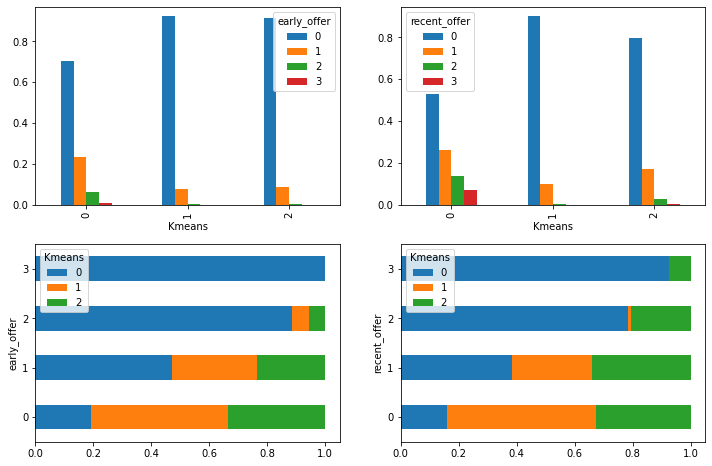

<AxesSubplot:xlabel='Kmeans', ylabel='NumDealsPurchases'>

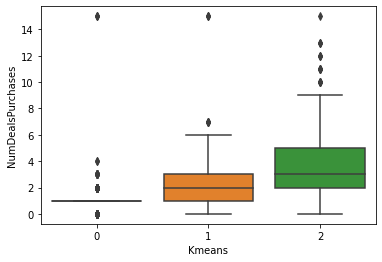

In [212]:
fig, axes = plt.subplots(2, 2,figsize=(12,8))
plt.subplots_adjust(hspace=0.2) 
pivot_percent.plot(kind='bar',stacked=False,ax=axes[0,0])
pivot_percent_1.plot(kind='bar',stacked=False,ax=axes[0,1])
pivot_percent_2.plot(kind='barh',stacked=True,ax=axes[1,0])
pivot_percent_3.plot(kind='barh',stacked=True,ax=axes[1,1])
plt.show()
sns.boxplot(data=DATA,y='NumDealsPurchases',x='Kmeans')

Here is the characteristics:
- **Cluster 0**: It does accept the most offer from the company from it's campaign but it also does the least one who purchase with discount. Here i see that perhaps there is less utilisation of offer (with the assumption that the offer is discount) or they do their discounted shopping at once. Additionally the few number of the purchase with discount could also mean that most of their purchase could be undiscounted products or high end product.
- **Cluster 1**: It is the cluster that accept the least of offer and the second most in puchasing with discount. Those two combination mean that perhaps they are almost maximizing their offer. But it also suggest that they do their shopping quite often but perhaps not too much purchases which is logical since they quite has the burden. Together with their age it seems that they do not has quite the time to accept the offer.
- **Cluster 2**: It is the one with the second most accepting of offer especially in the recent offer perhaps because this oldest group (by age and in touch) become more accustomed to the campaign. It is the one that mazimises the offer by doing the most purchases in discount perhaps to prepare for their teen's higher education and perhaps they also are quite busy and can only but small (perhaps) frequent purchases. 

### Hierarchical Agglomerative Clustering

In [213]:
pivot=DATA.groupby(['Hierarchical',promo[0]]).size().unstack().fillna(0)
pivot_percent=pivot.divide(pivot.sum(axis=1),axis=0)

In [214]:
pivot2=DATA.groupby([promo[0],'Hierarchical']).size().unstack().fillna(0)
pivot_percent_2=pivot2.divide(pivot2.sum(axis=1),axis=0)

In [215]:
pivot1=DATA.groupby(['Hierarchical',promo[1]]).size().unstack().fillna(0)
pivot_percent_1=pivot1.divide(pivot1.sum(axis=1),axis=0)

In [216]:
pivot3=DATA.groupby([promo[1],'Hierarchical']).size().unstack().fillna(0)
pivot_percent_3=pivot3.divide(pivot3.sum(axis=1),axis=0)

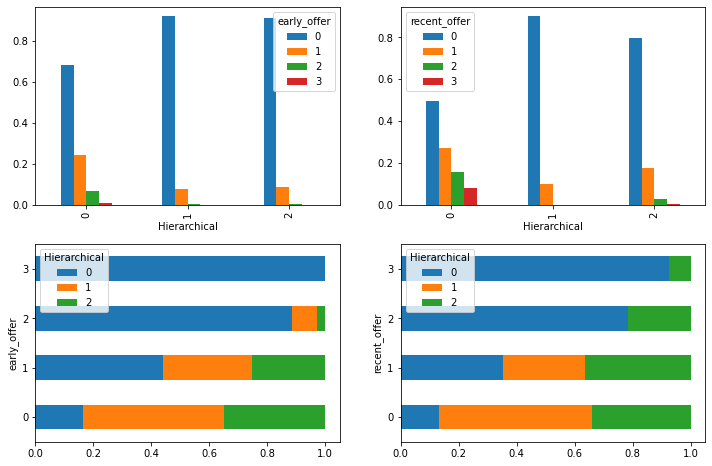

<AxesSubplot:xlabel='Hierarchical', ylabel='NumDealsPurchases'>

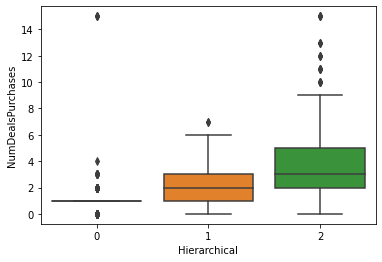

In [217]:
fig, axes = plt.subplots(2, 2,figsize=(12,8))
plt.subplots_adjust(hspace=0.2) 
pivot_percent.plot(kind='bar',stacked=False,ax=axes[0,0])
pivot_percent_1.plot(kind='bar',stacked=False,ax=axes[0,1])
pivot_percent_2.plot(kind='barh',stacked=True,ax=axes[1,0])
pivot_percent_3.plot(kind='barh',stacked=True,ax=axes[1,1])
plt.show()
sns.boxplot(data=DATA,y='NumDealsPurchases',x='Hierarchical')

The characteristics does show that they are the same with K-Means. But the dendogram below show why the cluster 1 and 2 is frequent purchases with deals because they are much closely related (green and red one).

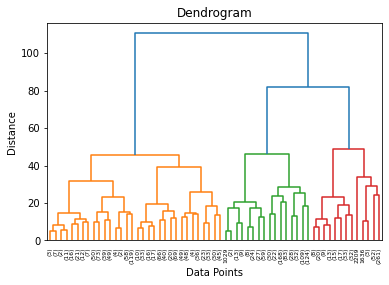

In [218]:
Z = sch.linkage(df, method='ward')

dendrogram = sch.dendrogram(Z, truncate_mode='level', p=5)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.show()

## 5.d.Place

### K-Means

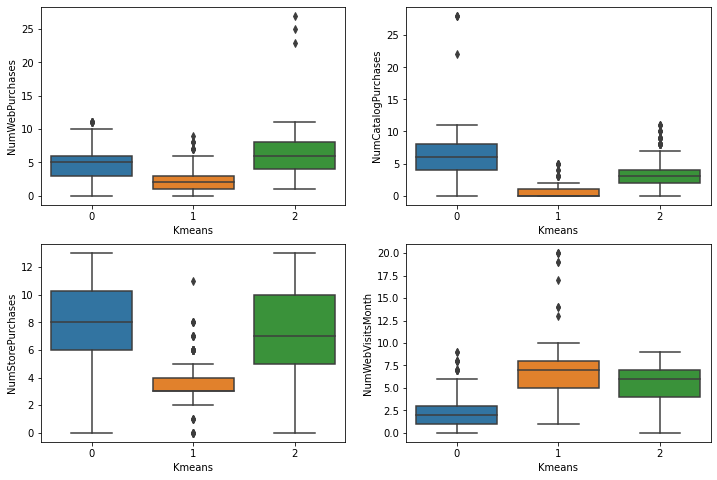

In [225]:
row=2
col=2
fig, axes = plt.subplots(row, col,figsize=(12,8))
plt.subplots_adjust(hspace=0.2) 
for i in range(row):
    for j in range(col):
        sns.boxplot(data=DATA, y=place[i*col+j],x='Kmeans',ax=axes[i,j])
plt.show()

Here is the characteristics of each cluster:
- **Cluster 0**: It has the most store and catalogue purchases. So they are more old fashioned perhaps because they are rich and has the time. It also has the least web visits per month. This suggest that most offer they get come from those sources perhaps and explain part of why they has least number of deal purchases is because they do not use web which is not addicting or compelling than store or catalogue. 
- **Cluster 1**: It has the lowest purchase in any place but they has the most web visit probably because searching for suitable offer which also explained why they also has frequent purchases. Most of their purchases come from web and store. They are likely to shop when there are suitable offers and since they also has kid they are quite frequent on shopping.
- **Cluster 2**: It has the second most web visit but most of them are probably for effective purchases. They are also quite balanced between web and store. Linked with the offer, i could see why despite only has the second accepting offer, they has the highest deal purchases is because they has the financial resources and they also has quite presence in the web purchases that also confirm that perhaps they are busy because they are working or others while need to take care their children (why has frequent purchases). 

### Hierarchical Agglomerative Clustering

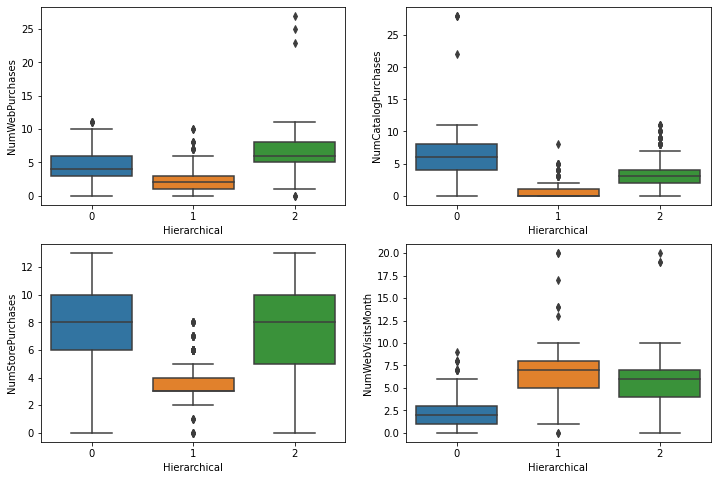

In [226]:
row=2
col=2
fig, axes = plt.subplots(row, col,figsize=(12,8))
plt.subplots_adjust(hspace=0.2) 
for i in range(row):
    for j in range(col):
        sns.boxplot(data=DATA, y=place[i*col+j],x='Hierarchical',ax=axes[i,j])
plt.show()

Literally is the same as the K-Means

# 6.Conclusion and Strategy for Each Cluster

## 6.a.Conclusion
- **Cluster 0**: It is the second oldest, has the highest income, and has no children, with second highest educational level and quite a single population which means that they has more time and money to actually purchase the most in value for grocery. They has the most acceptance of offer but did not used maximally because probably their products is not discounted or higher quality. They are more old fashioned that but most of their products on store or catalogue with minimal web visit.
- **Cluster 1**: It is the youngest but the most financially burdened (because has the most kids and lowest income) that has the lowest value for grocery purchase. This low value is because they are financially burdened which is why they despite did not quite active in accepting offer, use their suitable offer and discount in most of their shopping and they do frequent purchases because they also has kids. It has the most web visit not really used for purchases with their purchase conducted in web and store. this cluster also represented potential in future.
- **Cluster 2**: It is the oldest but has the middle in financial resources and burden (which could be vanished in near future). This cluster maximizes offer perhaps because they need to save for teen's high education or other by actually do frequent discount purchases and also second most in accepting offer (perhaps because has more resources). Their many deal purchases is perhaps testament on their huge visit to web for purchase (which usually are more addicting) and also their financial resources which are plentier than 1 to has more offer that is suitable.

## 6.b.Strategy for Each Cluster
Anyway the K-Means and Hierarchical clustering is the same anyway

Here is the name i think for the cluster:
- cluster 0: high value-old fashioned 
- cluster 1: value customer-family heavy but huge potential
- Cluster 2: medium value-maximizes offer and digitally active

Here is the strategy i think of:
- Cluster 0
    * Objective: retain the customer by providing exclusivity and quite personalised service and direct them to higher margin product
    * Promotion: Using staff in store or exclusive offer from the company which is delivered to them using catlog or though staff in store
    * Place: Make the store and catalogue to their taste and perhaps give them assistant when they are in store to help them when shopping
    * Product: Direct them to 'higher' quality produce or offer them something that usually not in store as personal services for their value
     
- Cluster 1
    * Objective: increase grocery value and engagement with them through web as well as provide better services for web purchases
    * Promotion: Give attractive promotion in web and also the promo could also lead them to good product and also benefits being given for web order
    * Place: Focused in web with store also need to be designed to make them buy higher value product
    * Product: Just focusing on retaining the current quality but if can upgrade them, focus in quantity could also be done
    
- Cluster 2
    * Objective: Retain customer with also providing realistic services for credit in this segment to stimulate growth and cultivate loyalty
    * Promotion: Get promo in web with value product and family oriented
    * Place: focuses on websites with tailored value offer and if possible do it at the same time
    * Product: Value product

# 7.Recommendation for Future Work
Here is my reccomendation for future steps:
1. I Hope that the data could provide better context especially in terms of what they offer in campaign. Having gender data and number of processed food being sold is also gonna make greater insight to the lifestyle of the customer
2. The Kidhome and Teenhome could be merge as one variable to give general context of the cluster characteristics
3. Get better method for tuning hyperparameter perhaps with Gap Statistucs to ensure that there is no model wasted
4. try to use k-Prototypes Algorithm as it is very suitable for mized data like this that could perhpas share different result as there is no need to encode categorical variable